# Transcriptional drift of Gene Ontology groupings

Tong Shu Li

Initial exploration of transcriptional drift of genes grouped by Gene Ontology annotations.

In [1]:
import numpy as np
import operator
import pandas as pd
import sys

from functools import reduce

In [2]:
%matplotlib inline

In [3]:
sys.path.append("..")

In [4]:
from src.load_gene_ont import load_go
from src.load_gene_ont import parse_go_defn

from src.plots import plot_drift
from src.plots import plot_drift_split_box
from src.plots import plot_p_val_heatmap

from src.stats import p_val_matrix

from src.util import subset

---

## Read the data

In [5]:
data = pd.read_csv("../data/worms_mianserin/avg_annotated_cpm_values.tsv", sep = '\t')

In [6]:
data.shape

(130548, 11)

In [7]:
data.head()

,seqname,sample,value,day_harvested,drug_conc_uM,day_drug_added,youngref,trans_drift,drug,wormbaseid,gene_symbol
0,2RSSE.1,1,4.105727,1,0,1,4.105726,-0.012915,water,WBGene00007064,2RSSE.1
1,2RSSE.1,2,7.687213,3,0,1,4.105726,0.562429,water,WBGene00007064,2RSSE.1
2,2RSSE.1,3,7.220500,5,0,1,4.105726,0.562490,water,WBGene00007064,2RSSE.1
3,2RSSE.1,4,3.923197,10,0,1,4.105726,-0.049039,water,WBGene00007064,2RSSE.1
4,2RSSE.1,5,4.042023,3,50,1,4.105726,-0.030335,mianserin,WBGene00007064,2RSSE.1


## Read the Gene Ontology for worms

In [8]:
floc = "../data/gene_ontology/gene_association.wb"
go_data = load_go(floc)

In [9]:
go_data.shape

(126496, 16)

In [10]:
go_data.head()

,database_id,db_obj_symbol,qualifier,go_id,db_ref,evidence,with_from,aspect,db_obj_name,db_obj_syn,db_obj_type,taxon,date,assigned_by,annot_ext,gene_prod_id
0,WBGene00000001,aap-1,NaN,GO:0005623,WB_REF:WBPaper00005614|PMID:12393910,IDA,NaN,C,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN
1,WBGene00000001,aap-1,NaN,GO:0005942,GO_REF:0000033,IBA,PANTHER:PTN000806614,C,NaN,Y110A7A.10,gene,taxon:6239,20150227,GO_Central,NaN,NaN
2,WBGene00000001,aap-1,NaN,GO:0005942,GO_REF:0000002,IEA,InterPro:IPR001720,C,NaN,Y110A7A.10,gene,taxon:6239,20150826,WB,NaN,NaN
3,WBGene00000001,aap-1,NaN,GO:0008286,WB_REF:WBPaper00005614|PMID:12393910,IMP,NaN,P,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN
4,WBGene00000001,aap-1,NaN,GO:0008340,WB_REF:WBPaper00005614|PMID:12393910,IMP,NaN,P,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN


## Read the names for each GO term

In [11]:
go_defn = parse_go_defn("../data/gene_ontology/go.obo")

In [12]:
go_defn.head()

,go_id,go_name
0,GO:0000001,mitochondrion inheritance
1,GO:0000002,mitochondrial genome maintenance
2,GO:0000003,reproduction
3,GO:0000005,obsolete ribosomal chaperone activity
4,GO:0000006,high-affinity zinc uptake transmembrane transp...


---

## Evidence codes

In [13]:
len(set(go_data["database_id"]))

12524

In [14]:
go_data["evidence"].value_counts()

IEA    89269
IBA    15537
IDA     6793
IMP     6418
IPI     3252
IGI     2355
ISS     1701
ND       360
IEP      323
NAS      198
TAS      189
IC        89
ISM       10
ISO        1
IKR        1
Name: evidence, dtype: int64

According to [this](http://geneontology.org/page/guide-go-evidence-codes), everything except "IEA" is assigned by a curator.

In [15]:
# number unique genes with human assigned GO terms
len(set(go_data.query("evidence != 'IEA'")["database_id"]))

6449

So we would only be examining ~50% of the total genes if we excluded this GO evidence type. Let's try it for now and come back to it later..

In [16]:
human_go = go_data.query("evidence != 'IEA'")

In [17]:
# number of genes in the rna seq and in the GO annotations
len(set(human_go["database_id"]) & set(data["wormbaseid"]))

4469

Only ~4500 genes in the RNA seq data have annotator assigned GO terms. This is very small!

In [18]:
len(set(go_data["database_id"]) & set(data["wormbaseid"]))

7822

Not that many more genes even if we include the computer assigned evidence codes.

---

## Distribution of genes by GO term

In [19]:
num_genes = human_go.groupby("go_id").apply(lambda f: len(set(f["database_id"])))

num_genes = num_genes.sort_values(ascending = False)

In [20]:
num_genes.describe()

count    4261.000000
mean        7.567238
std        32.788703
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       958.000000
dtype: float64

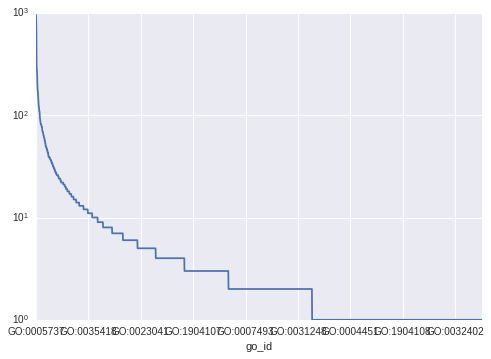

In [21]:
num_genes.plot(kind = "line", logy = True)

Distribution is very skewed to some mega gene groups. Not sure how the hierarchy comes into play here. Is each annotation as deep down the tree as possible? Assuming for now that we will only care about genes which are selected explicitly with the GO term.

In [22]:
num_genes.map(lambda v: 10 <= v < 1000).sum()

588

---

## Filtering methods

In [23]:
# save the gene names for each GO term
go_groups = {
    go_term: set(df["database_id"])
    for go_term, df in human_go.groupby("go_id")
}

In [24]:
def filter_go(go_terms, go_groups, dataframe):
    """Filters a dataframe down to genes belonging to the listed GO terms."""
    genes = reduce(operator.or_, (go_groups[term] for term in go_terms))
    
    temp = pd.DataFrame({"wormbaseid": list(genes)})
    return pd.merge(temp, dataframe, how = "inner", on = "wormbaseid")

## Hypothesis testing

Which GO terms have genes which increase in drift when worms are given water, but decrease when worms are given mianserin?

In [25]:
info = pd.DataFrame(
    [(go_term, len(genes)) for go_term, genes in go_groups.items()],
    columns = ["go_id", "num_genes"]
)

info = pd.merge(info, go_defn, how = "inner", on = "go_id")

In [26]:
good_genes = set(data["wormbaseid"])

info["num_in_data"] = info.loc[:, "go_id"].map(
    lambda v: len(good_genes & go_groups[v])
)

In [27]:
info.head()

,go_id,num_genes,go_name,num_in_data
0,GO:0017061,1,S-methyl-5-thioadenosine phosphorylase activity,1
1,GO:0048487,2,beta-tubulin binding,1
2,GO:0004057,1,arginyltransferase activity,1
3,GO:0051127,2,positive regulation of actin nucleation,2
4,GO:0006301,4,postreplication repair,4


In [28]:
(info["num_genes"] == info["num_in_data"]).sum()

2765

In [29]:
info.query("num_genes == num_in_data")["num_genes"].map(lambda f: 10 <= f < 1000).sum()

85

In [30]:
info["num_in_data"].map(lambda f: 10 <= f < 1000).sum()

469

---

## Proof of concept for a single GO term

In [31]:
term = "GO:0005666"
res = filter_go([term], go_groups, data.query("drug == 'water'"))

In [32]:
res.shape

(64, 11)

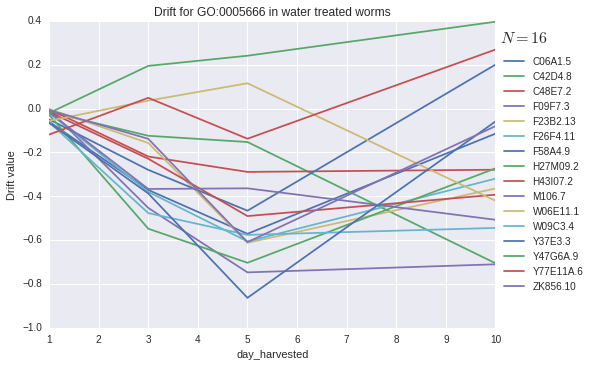

In [33]:
plot_drift(
    "line", res, "day_harvested", "trans_drift", "seqname",
    title = "Drift for {} in water treated worms".format(term)
)

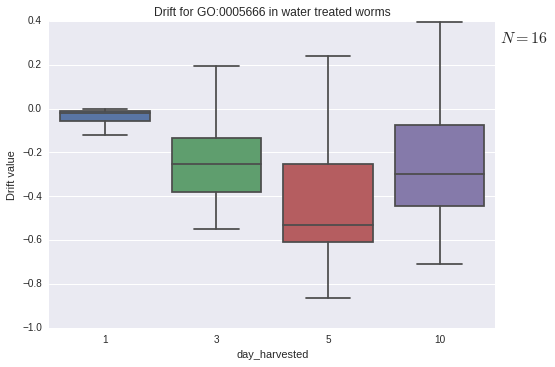

In [34]:
plot_drift(
    "box", res, "day_harvested", "trans_drift", "seqname",
    title = "Drift for {} in water treated worms".format(term)
)

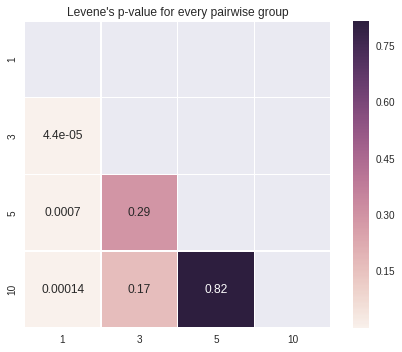

In [35]:
plot_p_val_heatmap(res, "day_harvested", "trans_drift")

---

## Start with the GO terms which have between 10 and 1000 genes

In [36]:
info.head()

,go_id,num_genes,go_name,num_in_data
0,GO:0017061,1,S-methyl-5-thioadenosine phosphorylase activity,1
1,GO:0048487,2,beta-tubulin binding,1
2,GO:0004057,1,arginyltransferase activity,1
3,GO:0051127,2,positive regulation of actin nucleation,2
4,GO:0006301,4,postreplication repair,4


In [37]:
water = data.query("drug == 'water'")

In [38]:
def drifts(go_term):
    res = filter_go([go_term], go_groups, water)
    
    p_vals = p_val_matrix(res, "day_harvested", "trans_drift")
    
    days = [1, 3, 5, 10]
    
    for day1, day2 in zip(days, days[1:]):
        if p_vals.loc[day2, day1] > 0.05:
            return False
        
    return True

smaller = info.query("num_in_data >= 10")
smaller["signif_drift_water"] = smaller.loc[:, "go_id"].map(drifts)

/home/toby/Research/Projects/ageing/venv/lib64/python3.4/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
smaller.shape

(469, 5)

In [40]:
smaller["signif_drift_water"].value_counts()

False    466
True       3
Name: signif_drift_water, dtype: int64

In [41]:
smaller.query("signif_drift_water")

,go_id,num_genes,go_name,num_in_data,signif_drift_water
514,GO:0045087,286,innate immune response,207,True
2693,GO:0019915,28,lipid storage,24,True
4108,GO:0005739,220,mitochondrion,203,True


## What do the drift plots look like for each of these GO groups?

## Lipid storage:

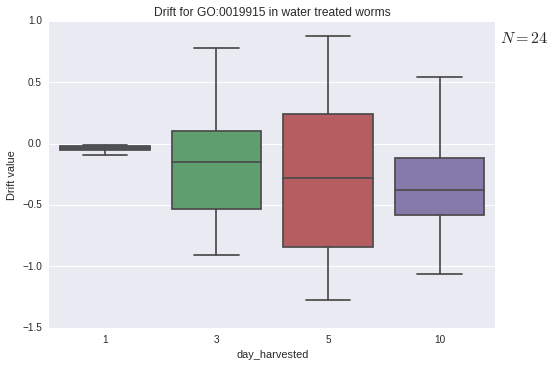

In [42]:
term = "GO:0019915"
res = filter_go([term], go_groups, water)
plot_drift(
    "box", res, "day_harvested", "trans_drift", "seqname",
    title = "Drift for {} in water treated worms".format(term)
)

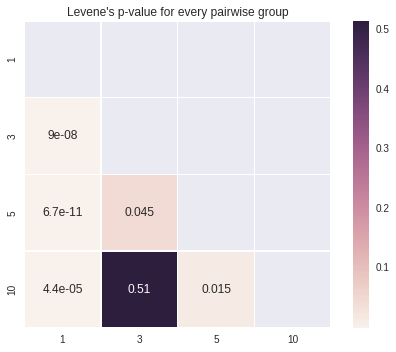

In [43]:
plot_p_val_heatmap(res, "day_harvested", "trans_drift")

## Mitochondrion

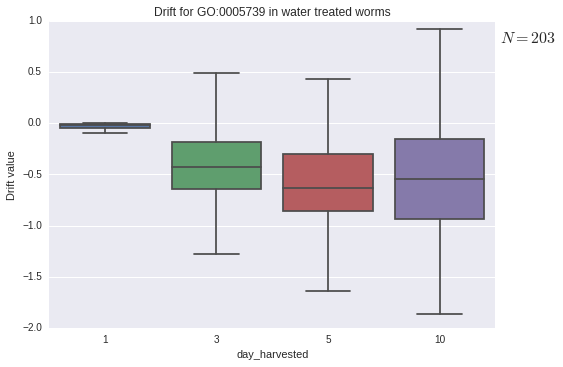

In [44]:
term = "GO:0005739"
res = filter_go([term], go_groups, water)
plot_drift(
    "box", res, "day_harvested", "trans_drift", "seqname",
    title = "Drift for {} in water treated worms".format(term)
)

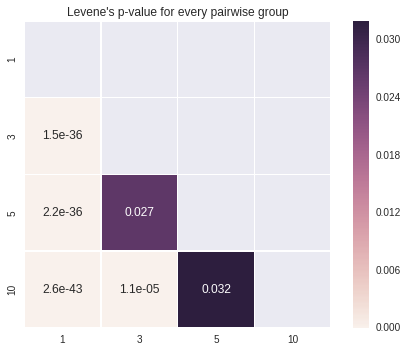

In [45]:
plot_p_val_heatmap(res, "day_harvested", "trans_drift")

## Innate immune response

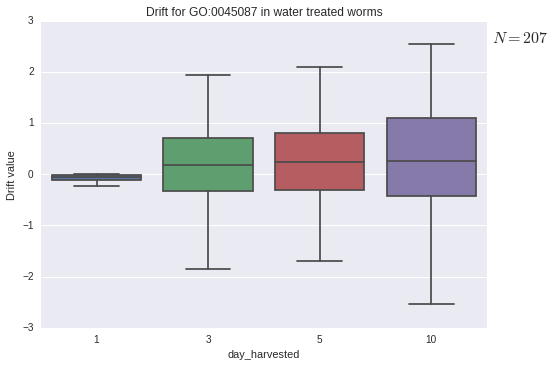

In [46]:
term = "GO:0045087"
res = filter_go([term], go_groups, water)
plot_drift(
    "box", res, "day_harvested", "trans_drift", "seqname",
    title = "Drift for {} in water treated worms".format(term)
)

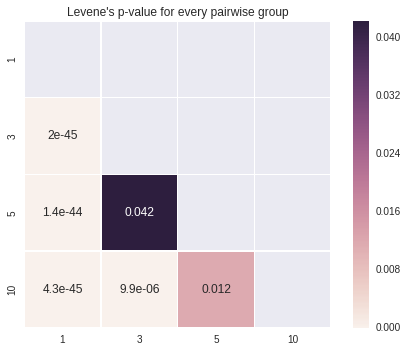

In [47]:
plot_p_val_heatmap(res, "day_harvested", "trans_drift")

---

## Do these three GO groups get reduced drift when given mianserin?

In [48]:
poss = smaller.query("signif_drift_water")

In [49]:
poss

,go_id,num_genes,go_name,num_in_data,signif_drift_water
514,GO:0045087,286,innate immune response,207,True
2693,GO:0019915,28,lipid storage,24,True
4108,GO:0005739,220,mitochondrion,203,True


## Mitochondrion

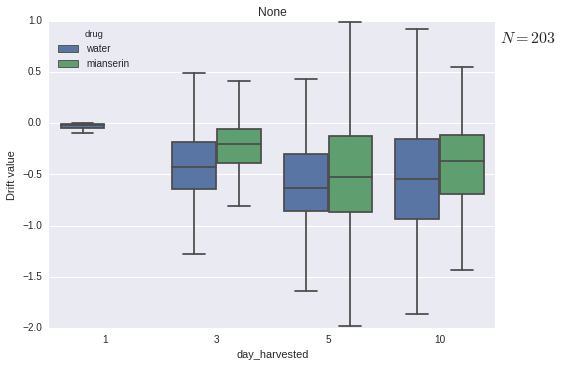

In [50]:
term = "GO:0005739"
temp = data.query("day_drug_added == 1")
temp = filter_go([term], go_groups, temp)

plot_drift(
    "box", temp, "day_harvested", "trans_drift", "seqname",
    groupby = "drug"
)

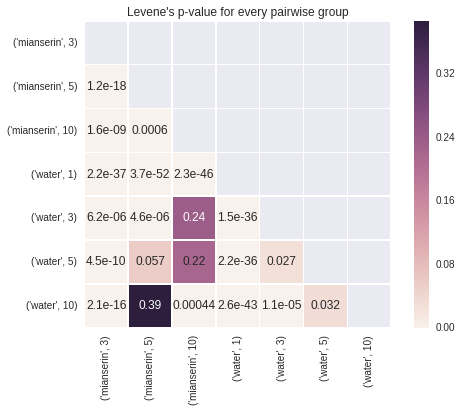

In [51]:
plot_p_val_heatmap(temp, ["drug", "day_harvested"], "trans_drift")

## Innate immune response

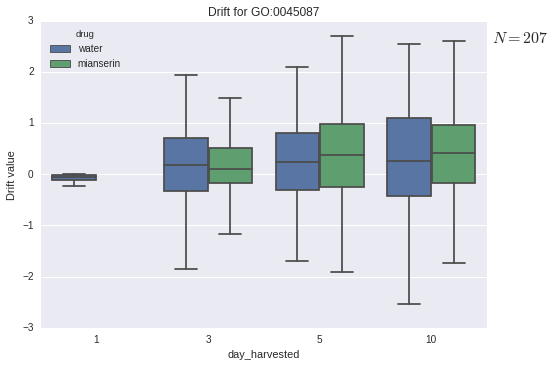

In [52]:
term = "GO:0045087"
temp = data.query("day_drug_added == 1")
temp = filter_go([term], go_groups, temp)

plot_drift(
    "box", temp, "day_harvested", "trans_drift", "seqname",
    groupby = "drug",
    title = "Drift for {}".format(term)
)

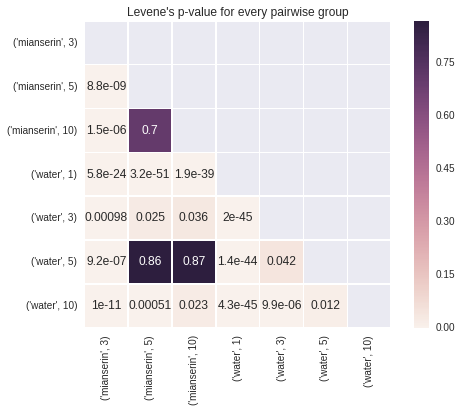

In [53]:
plot_p_val_heatmap(temp, ["drug", "day_harvested"], "trans_drift")

## Lipid storage

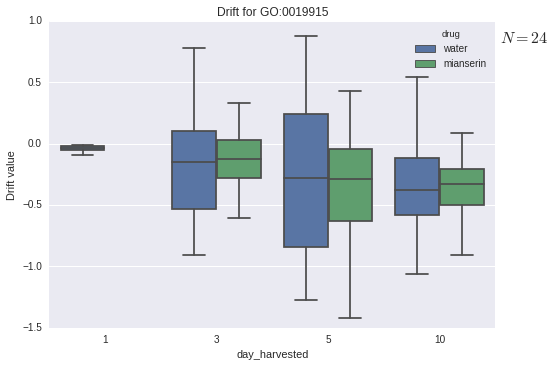

In [54]:
term = "GO:0019915"
temp = data.query("day_drug_added == 1")
temp = filter_go([term], go_groups, temp)

plot_drift(
    "box", temp, "day_harvested", "trans_drift", "seqname",
    groupby = "drug",
    title = "Drift for {}".format(term)
)

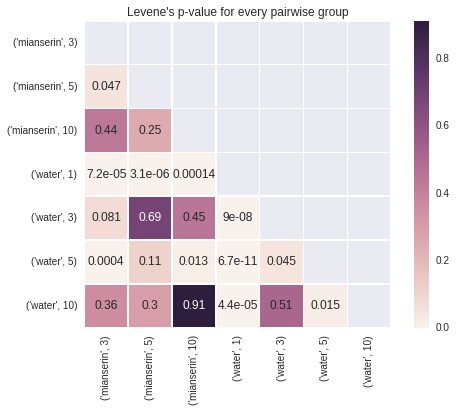

In [55]:
plot_p_val_heatmap(temp, ["drug", "day_harvested"], "trans_drift")

The data look a little strange. Day 5 for the mianserin treated worms seems to have the same drift variance as the water treated day 5 worms.

---

## Less stringent testing..

We didn't seem to find anything interesting, so we will relax our stringency. We will now look for genes in GO groups which:

1. Increased in drift in water from day 3 to 10.
2. Increased in drift in mianserin from day 3 to 10.
3. Decreased in drift on day 10 when given mianserin.

In [56]:
info.shape

(4260, 4)

In [57]:
info.head()

,go_id,num_genes,go_name,num_in_data
0,GO:0017061,1,S-methyl-5-thioadenosine phosphorylase activity,1
1,GO:0048487,2,beta-tubulin binding,1
2,GO:0004057,1,arginyltransferase activity,1
3,GO:0051127,2,positive regulation of actin nucleation,2
4,GO:0006301,4,postreplication repair,4


## Drift increased in water from day 3 to 10

In [58]:
water = data.query("drug == 'water'")

def drifts2(go_term):
    res = filter_go([go_term], go_groups, water)
    
    p_vals = p_val_matrix(res, "day_harvested", "trans_drift")
    return p_vals.loc[10, 3] < 0.05

smaller = info.query("num_in_data >= 10")
smaller["signif_water310"] = smaller.loc[:, "go_id"].map(drifts2)

/home/toby/Research/Projects/ageing/venv/lib64/python3.4/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [59]:
smaller.head()

,go_id,num_genes,go_name,num_in_data,signif_water310
7,GO:0042738,39,exogenous drug catabolic process,20,False
8,GO:0043051,38,regulation of pharyngeal pumping,30,False
10,GO:0003697,15,single-stranded DNA binding,14,False
22,GO:0005623,39,cell,30,False
25,GO:0048598,36,embryonic morphogenesis,34,False


In [60]:
smaller["signif_water310"].value_counts()

False    415
True      54
Name: signif_water310, dtype: int64

In [61]:
interesting = smaller.query("signif_water310").sort_values("num_in_data", ascending = False)

## Now we look for increased drift in mianserin from day 3 to 10

In [62]:
temp = data.query("day_drug_added == 1")

In [63]:
def drifts4(go_term):
    res = filter_go([go_term], go_groups, temp)
    
    p_vals = p_val_matrix(res, ["drug", "day_harvested"], "trans_drift")
    
    v1 = ("mianserin", 10)
    v2 = ("mianserin", 3)
    
    assert p_vals.at[v1, v2] != np.nan
    
    # p_vals.loc[[v1], [v2]] won't work since it will return a single 1by1 dataframe
    # the .at function returns the single value
    return p_vals.at[v1, v2] < 0.05

interesting["signif_mianserin310"] = interesting.loc[:, "go_id"].map(drifts4)

## Look for GO groups which were reduced in drift on day 10 when given mianserin

In [64]:
def drifts3(go_term):
    res = filter_go([go_term], go_groups, temp)
    
    p_vals = p_val_matrix(res, ["drug", "day_harvested"], "trans_drift")
    
    v1 = ("water", 10)
    v2 = ("mianserin", 10)
    
    assert p_vals.at[v1, v2] != np.nan
    
    # p_vals.loc[[v1], [v2]] won't work since it will return a single 1by1 dataframe
    # the .at function returns the single value
    return p_vals.at[v1, v2] < 0.05

interesting["signif_mianserin10"] = interesting.loc[:, "go_id"].map(drifts3)

In [65]:
interesting["signif_mianserin10"].value_counts()

True     33
False    21
Name: signif_mianserin10, dtype: int64

In [66]:
interesting["signif_mianserin310"].value_counts()

True     36
False    18
Name: signif_mianserin310, dtype: int64

In [67]:
good = interesting.query("signif_mianserin10 & signif_water310 & signif_mianserin310")

In [68]:
good

,go_id,num_genes,go_name,num_in_data,signif_water310,signif_mianserin310,signif_mianserin10
436,GO:0005515,924,protein binding,811,True,True,True
2767,GO:0005737,958,cytoplasm,751,True,True,True
3953,GO:0005634,725,nucleus,586,True,True,True
2822,GO:0005886,308,plasma membrane,214,True,True,True
514,GO:0045087,286,innate immune response,207,True,True,True
4108,GO:0005739,220,mitochondrion,203,True,True,True
2808,GO:0005829,175,cytosol,152,True,True,True
3062,GO:0008340,162,determination of adult lifespan,136,True,True,True
1237,GO:0003674,170,molecular_function,116,True,True,True
1310,GO:0016021,175,integral component of membrane,112,True,True,True


In [69]:
good.shape

(26, 7)

## Check our work

## Centrosome

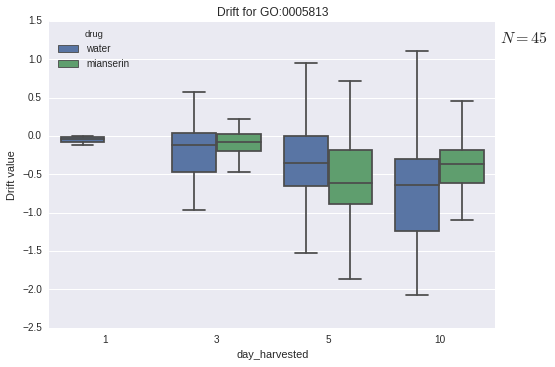

In [70]:
temp = data.query("day_drug_added == 1")

term = "GO:0005813"
sub = filter_go([term], go_groups, temp)
plot_drift(
    "box", sub, "day_harvested", "trans_drift", "seqname", groupby = "drug",
    title = "Drift for {}".format(term)
)

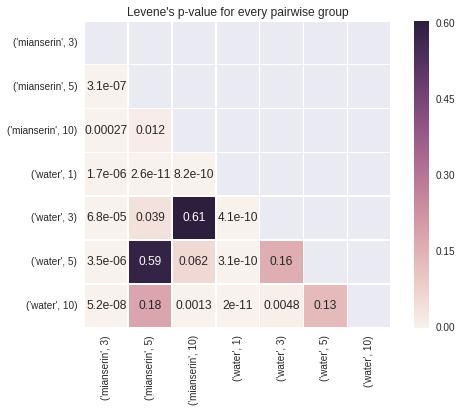

In [71]:
plot_p_val_heatmap(sub, ["drug", "day_harvested"], "trans_drift")

## Amino acid transmembrane transporter activity

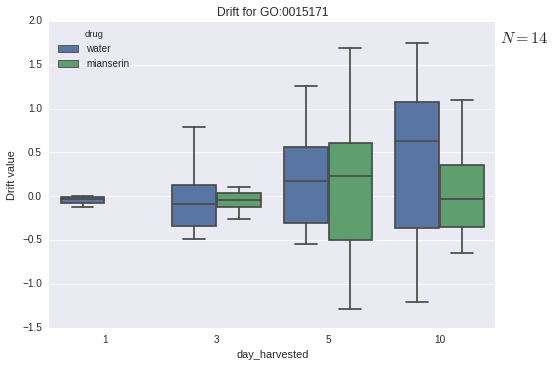

In [72]:
temp = data.query("day_drug_added == 1")

term = "GO:0015171"
sub = filter_go([term], go_groups, temp)
plot_drift(
    "box", sub, "day_harvested", "trans_drift", "seqname", groupby = "drug",
    title = "Drift for {}".format(term)
)

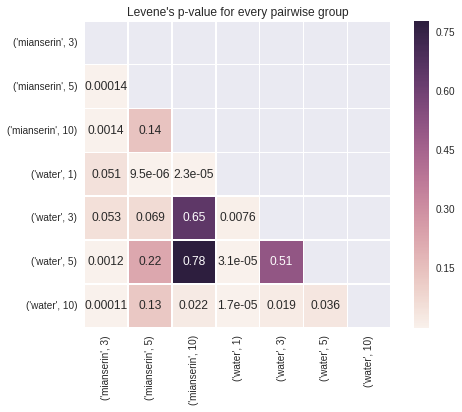

In [73]:
plot_p_val_heatmap(sub, ["drug", "day_harvested"], "trans_drift")

Again it seems that something is wrong with the day 5 mianserin samples, so those will need further inspection.